In [ ]:
#default_exp ch01_problem01

# basic

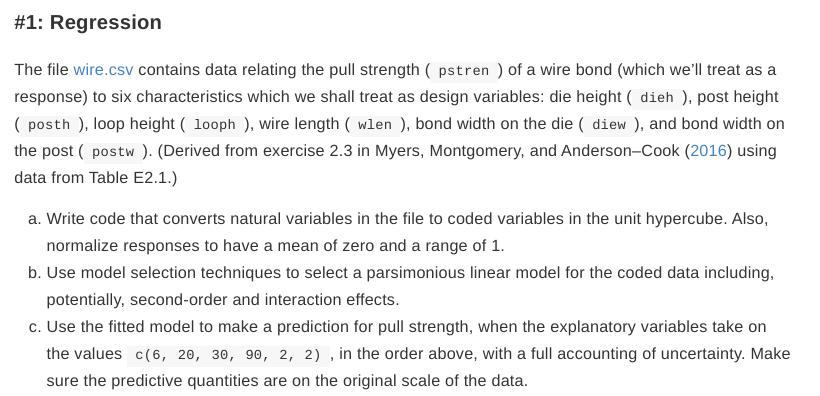

In [2]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [3]:
#hide
#export
from nbdev.showdoc import *
import pandas as pd
import numpy as np
import plotnine as pn
from typing import List
from sklearn.linear_model import LinearRegression

In [5]:
#export

def length(x: pd.Series):
    return np.sqrt(np.sum(np.square(x)))


class DataManager:
    def __init__(self, data: pd.DataFrame = None, response="pstren", 
                 datafile="http://bobby.gramacy.com/surrogates/wire.csv"):
        self.data = data
        if self.data is None:            
            self.data = pd.read_csv(datafile)
        self.data.columns = [s.strip() for s in self.data.columns]
        self.response: str = response
        self.predictors: List[str] = self._get_predictors()
        self.normalized = False
        self.hypercubed = False
        self.orig_lengths = {}

    
    def spawn(self, new_data: pd.DataFrame):
        new = DataManager(data=new_data.copy(), response=self.response)
        new.orig_mean = self.orig_mean
        new.orig_std  = self.orig_std
        new.orig_lengths = self.orig_lengths.copy()
        return new


    def _get_predictors(self) -> List[str]:
        return [colname for colname in self.data.columns if colname != self.response]

    
    def predictors_to_hypercube(self):
        """ Scales each predictor to length 1. """
        if self.hypercubed:
            raise AssertionError("Predictors already scaled to hypercube.")
        for colname in self.predictors:
            try:
                # Use the original if it exists. 
                # Useful for spawned managers - they'll use the 
                # parent original lengths.
                orig_length = self.orig_lengths[colname]
            except KeyError:
                orig_length = length(self.data[colname])
            self.orig_lengths[colname] = orig_length
            self.data[colname] /= orig_length
        self.hypercubed = True
            

    def normalize_response(self):
        """
        Scales the response to a mean of 0 and standard deviation of 1.
        """
        if self.normalized:
            raise AssertionError("Response already scaled to (mean, std) = (0, 1).")
        self.orig_mean = np.mean(self.data[self.response])
        self.orig_std = np.std(self.data[self.response])
        self.data[self.response] -= self.orig_mean
        self.data[self.response] /= self.orig_std        
        self.normalized = True
        
        
    def unscale_prediction(self, pred: float):
        return pred * self.orig_std + self.orig_mean
        


    def make_quadratic_variables_wide(self) -> pd.DataFrame:
        """
        Returns a matrix with one column per variable combination, i.e.
        all the cross-multiplications. Also with one column per original variable.
        """
        interactions = {}
        for i, coli in enumerate(self.predictors):            
            interactions[coli] = self.data[coli]
            for j in range(i, len(self.predictors)):
                colj = self.predictors[j]
                interactions[f"{coli}*{colj}"] = self.data[coli] * self.data[colj]
        return pd.DataFrame(interactions)

    
    def make_quadratic_variables_long(self, wide=None):
        if wide is None:
            wide = self.make_quadratic_variables_wide()
        dfs = []
        idx = range(wide.shape[0])
        for colname in wide.columns:
            df = pd.DataFrame({'val': wide[colname]})
            df['var'] = colname
            df['response'] = self.data[self.response]
            dfs.append(df)
        return pd.concat(dfs)[['var', 'val', 'response']]


    def make_grid(self, x1_name, x2_name) -> pd.DataFrame:
        """
        Makes a dataframe with the columns (var, x1, x2, self.response),
        where var is some string variable combination (e.g. s * t), x1 is the value 
        of s, x2 is the value of t, and self.response is the value of the response
        at that actual s, t combination in the data.
        """
        df = self.data[[x1_name, x2_name, self.response]]
        df.columns = ['x1', 'x2', self.response]
        
        df['var'] = f"{x1_name}*{x2_name}"
        return df.drop_duplicates()


    def make_grids(self) -> pd.DataFrame:
        """
        Applies make_grid for every variable combination in the data.
        """
        dfs = []
        icols = self.predictors
        for i in range(len(self.predictors)):
            dfs.append(self.make_grid(self.predictors[i], self.predictors[i]))
            for j in range(i - 1, len(self.predictors)):
                df = self.make_grid(self.predictors[i], self.predictors[j])
                dfs.append(df)
        return pd.concat(dfs)
    

    def get_linear_slopes(self, grids_df):
        """
        Returns a dataframe with each variable in grids_df, and the size
        of each linear slope when a predictor on only that variable
        is fit to this manager's data.
        """
        slope_rows = []
        for name, df in grids_df.groupby('var'):
            model = LinearRegression()
            X = pd.DataFrame(df['x1'] * df['x2']).values
            y = df[self.response].values
            model.fit(X, y)
            assert len(model.coef_) == 1
            slope = model.coef_[0]
            row = (name, slope)
            slope_rows.append(row)
            
        for name in self.predictors:
            df = grids_df[grids_df['var'] == f"{name}*{name}"]
            df = df.iloc[0:self.data.shape[0], :]
            
            if df.shape[0] != self.data.shape[0]:
                print(df)
                raise AssertionError(f"got {df.shape[0]} rows but expected {self.data.shape[0]}")
            X, y = pd.DataFrame(df['x1']).values, df[self.response].values
            model = LinearRegression().fit(X, y)            
            assert len(model.coef_) == 1
            slope_rows.append((name, model.coef_[0]))
        slopes_df = pd.DataFrame(slope_rows, columns=['var', 'slope'])
        slopes_df['abs_slope'] = slopes_df['slope'].abs()
        return slopes_df.sort_values('abs_slope', ascending=False)

    
wires_facet_theme = pn.theme(
    subplots_adjust={'hspace': 0.25}, 
    figure_size=(18, 15))


def attach_std(pred_df: pd.DataFrame, variance: np.array) -> None:
    pred_df['lb'] = pred_df['pred'] - np.sqrt(variance)
    pred_df['ub'] = pred_df['pred'] + np.sqrt(variance)


def plot_scatter(dat, figsize=(16, 12)):
    return (
        pn.ggplot(dat, pn.aes(x='val', y='response')) +
        pn.geom_point() +
        pn.geom_smooth(method='lm') +
        pn.facet_wrap("var", scales='free_x') +
        pn.theme_bw() +
        pn.theme(figure_size=figsize, subplots_adjust={'hspace': 0.25}))


def plot_predictions_actual(pred_df, figsize):
    return (
        pn.ggplot(pred_df, pn.aes(x='y', y='pred')) +
        pn.geom_point() +
        pn.geom_ribbon(pn.aes(ymin='lb', ymax='ub'), alpha=0.3) +
        pn.geom_abline(slope=1, intercept=0) + 
        pn.theme_bw() +
        pn.theme(figure_size=figsize))


def plot_predictions_residuals(pred_df, figsize):
    return (
        pn.ggplot(pred_df, pn.aes(x='y', y='resid')) +
        pn.geom_point() +
        pn.geom_hline(yintercept=0) + 
        pn.theme_bw() +
        pn.theme(figure_size=figsize))


def plot_predictions(pred_df, figsize):
    actual = plot_predictions_actual(pred_df, figsize) + pn.ggtitle('actuals')
    display(actual);
    resid = plot_predictions_residuals(pred_df, figsize) + pn.ggtitle('residuals')
    display(resid);

In [6]:
dm = DataManager()
dm.data.head()

,pstren,dieh,posth,looph,wlen,diew,postw
0,8.0,5.2,19.6,29.6,94.9,2.1,2.3
1,8.3,5.2,19.8,32.4,89.7,2.1,1.8
2,8.5,5.8,19.6,31.0,96.2,2.0,2.0
3,8.8,6.4,19.4,32.4,95.6,2.2,2.1
4,9.0,5.8,18.6,28.6,86.5,2.0,1.8


---------
### Write code that converts natural variables in the file to coded variables in the unit hypercube. Also, normalize responses to have a mean of zero and a range of 1.

In [7]:
dm.predictors_to_hypercube()
dm.normalize_response()
dm.data.head()

,pstren,dieh,posth,looph,wlen,diew,postw
0,-1.612024,0.205221,0.231706,0.210582,0.245585,0.230895,0.269972
1,-1.385147,0.205221,0.234071,0.230502,0.232129,0.230895,0.211283
2,-1.233895,0.228901,0.231706,0.220542,0.248950,0.219900,0.234759
3,-1.007018,0.252580,0.229342,0.230502,0.247397,0.241890,0.246497
4,-0.855766,0.228901,0.219884,0.203468,0.223848,0.219900,0.211283


In [8]:
# Test data standardization.
for colname in dm.predictors:
    x = dm.data[colname]
    assert x.max() <= 1    
    assert x.min() >= 0
    1 - length(x) <= 10e-7

---------
### Use model selection techniques to select a parsimonious linear model for the coded data including, potentially, second-order and interaction effects.

In [9]:
quadratics_wide = dm.make_quadratic_variables_wide()
quadratics_long = dm.make_quadratic_variables_long(quadratics_wide)

In [10]:
quadratics_wide.head()

,dieh,dieh*dieh,dieh*posth,dieh*looph,dieh*wlen,dieh*diew,dieh*postw,posth,posth*posth,posth*looph,...,looph*postw,wlen,wlen*wlen,wlen*diew,wlen*postw,diew,diew*diew,diew*postw,postw,postw*postw
0,0.205221,0.042116,0.047551,0.043216,0.050399,0.047385,0.055404,0.231706,0.053688,0.048793,...,0.056851,0.245585,0.060312,0.056704,0.066301,0.230895,0.053312,0.062335,0.269972,0.072885
1,0.205221,0.042116,0.048036,0.047304,0.047638,0.047385,0.043360,0.234071,0.054789,0.053954,...,0.048701,0.232129,0.053884,0.053597,0.049045,0.230895,0.053312,0.048784,0.211283,0.044640
2,0.228901,0.052395,0.053038,0.050482,0.056985,0.050335,0.053736,0.231706,0.053688,0.051101,...,0.051774,0.248950,0.061976,0.054744,0.058443,0.219900,0.048356,0.051623,0.234759,0.055112
3,0.252580,0.063797,0.057927,0.058220,0.062488,0.061097,0.062260,0.229342,0.052598,0.052864,...,0.056818,0.247397,0.061205,0.059843,0.060982,0.241890,0.058511,0.059625,0.246497,0.060761
4,0.228901,0.052395,0.050332,0.046574,0.051239,0.050335,0.048363,0.219884,0.048349,0.044739,...,0.042989,0.223848,0.050108,0.049224,0.047295,0.219900,0.048356,0.046461,0.211283,0.044640


In [11]:
grids_df = dm.make_grids()
grids_df.head()

<ipython-input-5-5c32dab42461>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,x1,x2,pstren,var
0,0.205221,0.205221,-1.612024,dieh*dieh
1,0.205221,0.205221,-1.385147,dieh*dieh
2,0.228901,0.228901,-1.233895,dieh*dieh
3,0.252580,0.252580,-1.007018,dieh*dieh
4,0.228901,0.228901,-0.855766,dieh*dieh


In [12]:
slopes_df = dm.get_linear_slopes(grids_df)

In [13]:
plot_vars = quadratics_wide.columns
plot_df = quadratics_long[quadratics_long['var'].apply(lambda s: s in plot_vars)]
order = list(slopes_df['var'])
memberships = plot_df['var'].apply(lambda s: s in order)
plot_df[~memberships]
plot_df['var'] = pd.Categorical(list(plot_df['var']), categories=list(slopes_df['var']))

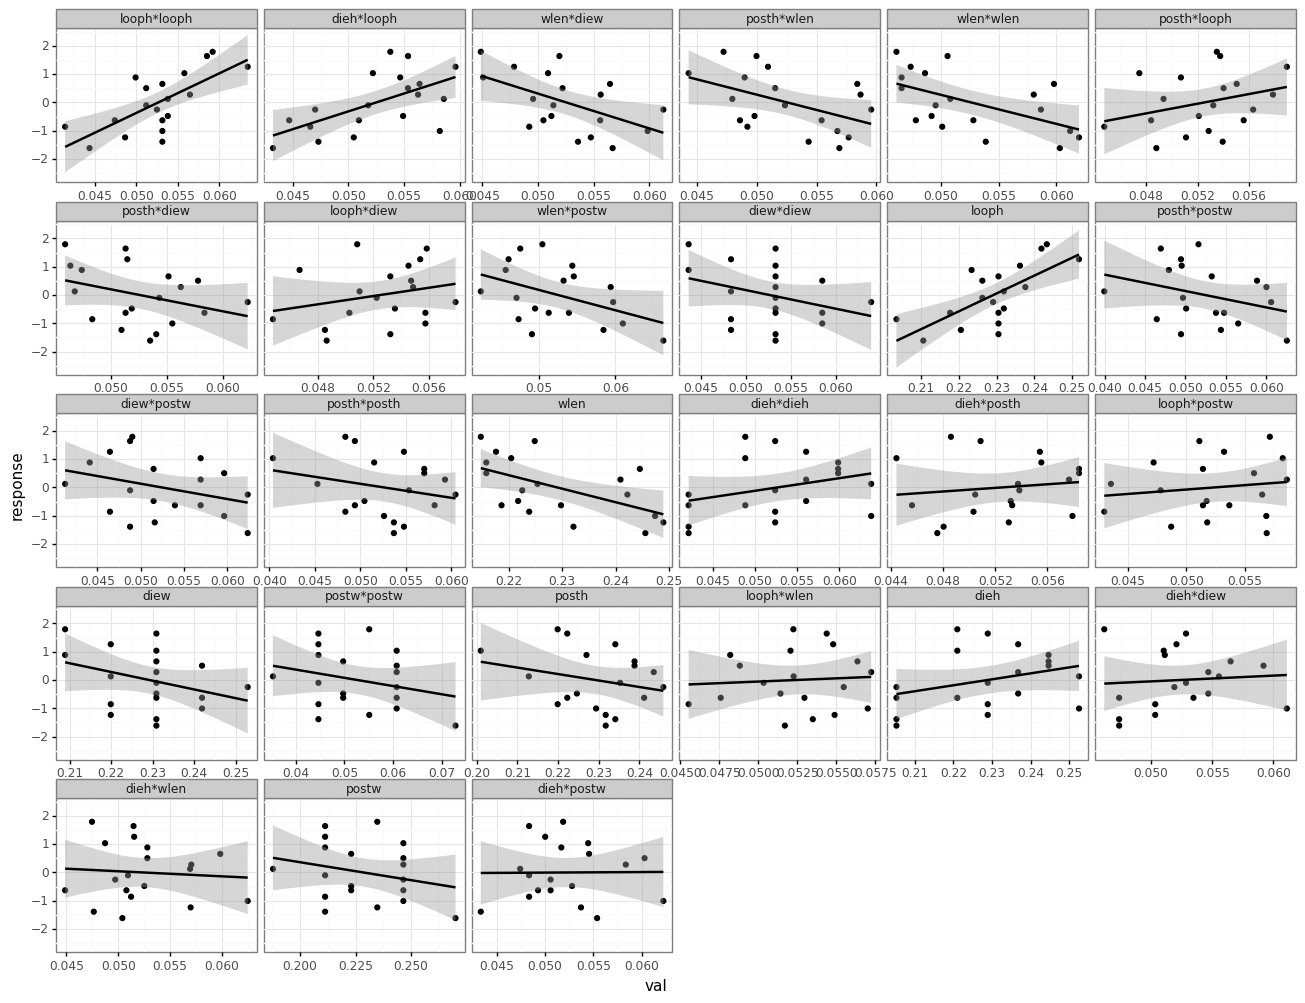

<ggplot: (8492891988727)>

In [32]:
all_data_plot = plot_scatter(plot_df)
display(all_data_plot)

In [15]:
variables = ['looph*looph', 'dieh*looph', 'wlen*diew', 'posth*wlen', 'wlen*wlen']

We'll fit using these predictors:

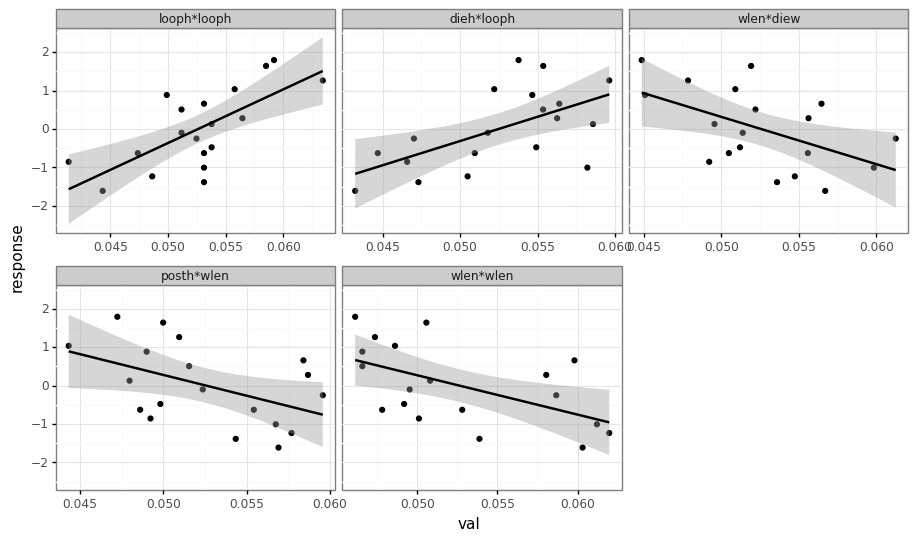

<ggplot: (8492892132425)>

In [31]:
selected_plot_df = plot_df[plot_df['var'].apply(lambda s: s in variables)]
display(plot_scatter(selected_plot_df, (11, 6)))

In [17]:
y = dm.data[dm.response].values

In [18]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
LASSO = False
if LASSO:
    variables = list(quadratics_wide.columns)
    X = quadratics_wide[variables].values
    model = LassoLarsIC(criterion='bic')#, normalize=False, fit_intercept=False)
    model.fit(X, y)
    pred = model.predict(X)
else:
    X = quadratics_wide[variables].values
    y = dm.data[dm.response].values
    model = LinearRegression().fit(X, y)
    pred = model.predict(X)    

In [19]:
pred_df = pd.DataFrame(X, columns=variables).assign(y=y, pred=pred, resid=lambda d: d['y'] - d['pred'])
pred_var = pred_df['resid'].var()
attach_std(pred_df, pred_var)

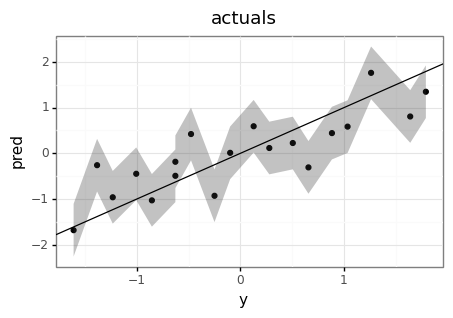

<ggplot: (8492893806939)>

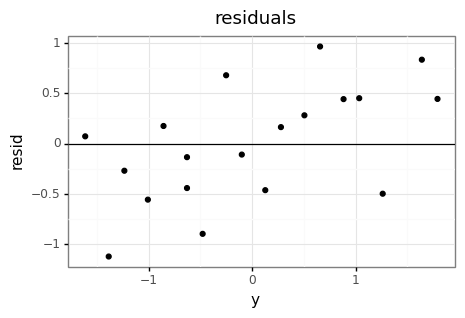

<ggplot: (8492894117488)>

In [20]:
results_figsize = (5, 3)
plot_predictions(pred_df, results_figsize);

## Predict on a new record.

In [21]:
target_array = [6, 20, 30, 90, 2, 2]
target_df = pd.DataFrame(columns=dm.predictors)
target_df.loc[0, :] = target_array
assert target_df.shape == (1, len(dm.predictors)) == (1, len(target_array))
target_df

,dieh,posth,looph,wlen,diew,postw
0,6,20,30,90,2,2


In [22]:
target_dm = dm.spawn(target_df)
target_dm.predictors_to_hypercube()
target_quadratic_wide = target_dm.make_quadratic_variables_wide()

In [23]:
target_X = target_quadratic_wide[variables]
target_y = model.predict(target_X)
assert target_y.shape == (1,)
target_y = target_y[0]
interval = (target_y - np.sqrt(pred_var), target_y, target_y + np.sqrt(pred_var))

In [24]:
[target_dm.unscale_prediction(val) for val in interval]

[8.348382408870796, 9.110313690523249, 9.872244972175704]

In [26]:
from nbdev.export import *
notebook2script()

Converted ch01_problem01.ipynb.
Converted ch01_problem02.ipynb.
Converted ch01_problem03.ipynb.
Converted index.ipynb.
